# 사전 훈련된 PyTorch 모델을 SageMaker Neo로 컴파일 후 Inf1 인스턴스에 배포하기

---

이 노트북에서는 사전 훈련된 `mnasnet` 모델을 SageMaker Neo로 컴파일 후, Inf1 인스턴스로 배포합니다. SageMaker Neo로 컴파일한 모델은 
클라우드와 엣지 디바이스 어디에서나 실행할 수 있습니다. 또한, Inf1 인스턴스는 머신 러닝 추론 애플리케이션을 지원하기 위해 구축된 추론 전용 인스턴스이며, AWS에서 설계 및 구축한 고성능 머신 러닝 추론 칩인 AWS Inferentia 칩이 최대 16개 내장되어 있습니다.

2021년 1월 기준으로 torchvision의 사전 훈련 모델을 지원하고 있으며 클라우드 인스턴스와 엣지 디바이스에서 PyTorch 1.4.0을 지원하고 있으며, AWS Inferentia에서 PyTorch 1.5.1을 지원하고 있습니다.

SageMaker Neo가 지원하는 인스턴스 타입, 하드웨어 및 딥러닝 프레임워크는 아래 링크를 참조해 주세요.
- 클라우드 인스턴스: https://docs.aws.amazon.com/sagemaker/latest/dg/neo-supported-cloud.html
- 엣지 디바이스: https://docs.aws.amazon.com/sagemaker/latest/dg/neo-supported-devices-edge.html

또한, SageMaker 인프라 상에서 PyTorch로 추론을 수행하는 튜토리얼 노트북 예제는 [pytorch-serving-endpoint.ipynb](pytorch-serving-endpoint.ipynb) 를 참조해 주세요.

In [1]:
%load_ext autoreload
%autoreload 2

SageMaker SDK를 최신 버전으로 업그레이드합니다. 본 노트북은 SDK 2.x 버전 이상에서 구동해야 합니다.

In [2]:
import sys, sagemaker
!{sys.executable} -m pip install -qU "sagemaker>=2.11.0"
print(sagemaker.__version__)

**[주의]** 주피터 노트북에 설치된 PyTorch 및 TorchVision 버전은 각각 1.4.0과 0.5.0이어야 합니다. SageMaker 노트북 인스턴스 상에서 본 예제를 실행한다면 아래 코드 셀을 주석 처리하지 말고 그대로 실행해 주세요.

In [3]:
!~/anaconda3/envs/pytorch_p36/bin/pip install -qU torch==1.4.0 torchvision==0.5.0

<br>

# 1. 단일 코어로 모델 컴파일 후 배포
---
우선, 이 섹션에서는 컴파일의 기본 설정값인 단일 코어로 모델을 컴파일합니다.
다음 섹션에서 컴파일러 옵션을 사용하여 다중 코어에 대한 모델을 컴파일하는 방법을 살펴 보겠습니다.

## Inference Script


In [4]:
%%writefile src/inference_pytorch_inf1.py

def input_fn(request_body, request_content_type):
    import torch
    import torchvision.transforms as transforms
    from PIL import Image
    import io
    f = io.BytesIO(request_body)
    input_image = Image.open(f).convert('RGB')
    preprocess = transforms.Compose([
      transforms.Resize(255),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)
    return input_batch

Overwriting src/inference_pytorch_inf1.py


## Import pre-trained model from TorchVision

본 예제는 TorchVision의 pre-trained 모델 중 MnasNet을 사용합니다.
MnasNet은 정확도(accuracy)와 모바일 디바이스의 latency를 모두 고려한 강화학습 기반 NAS(neural architecture search)이며, TorchVision은 image classification에 최적화된 MNasNet-B1을 내장하고 있습니다. 
(참조 논문: https://arxiv.org/pdf/1807.11626.pdf)

In [5]:
import torch
import torchvision.models as models
import tarfile

model = models.mnasnet1_0(pretrained=True)
input_shape = [1,3,224,224]
trace = torch.jit.trace(model.float().eval(), torch.zeros(input_shape).float())
trace.save('model.pth')

with tarfile.open('model.tar.gz', 'w:gz') as f:
    f.add('model.pth')
    f.add('src/inference_pytorch_neo.py')

## 모델 아티팩트 S3로 전송

In [6]:
import boto3
import sagemaker
import time
from sagemaker.utils import name_from_base

role = sagemaker.get_execution_role()
sess = sagemaker.Session()
region = sess.boto_region_name
bucket = sess.default_bucket()

compilation_job_name = name_from_base('TorchVision-MnasNet-Neo-Inf1')

model_key = '{}/model/model.tar.gz'.format(compilation_job_name)
model_path = 's3://{}/{}'.format(bucket, model_key)
boto3.resource('s3').Bucket(bucket).upload_file('model.tar.gz', model_key)
print("Uploaded model to s3:")
print(model_path)

sm_client = boto3.client('sagemaker')
compiled_model_path = 's3://{}/{}/output'.format(bucket, compilation_job_name)
print("Output path for compiled model:")
print(compiled_model_path)

Uploaded model to s3:
s3://sagemaker-us-east-1-143656149352/TorchVision-MnasNet-Neo-Inf1-2020-12-31-05-27-16-926/model/model.tar.gz
Output path for compiled model:
s3://sagemaker-us-east-1-143656149352/TorchVision-MnasNet-Neo-Inf1-2020-12-31-05-27-16-926/output


## 모델 컴파일
모델을 Inf1 인스턴스에 배포하기 전, SageMaker Neo를 사용하여 모델을 컴파일하여 배포 대상 디바이스 및 인스턴스에 대한 성능을 최적화합니다.
Inf1 인스턴스에 배포할 모델을 컴파일하기 위해 `target_instance_family='ml_inf1'`을 설정하세요.

In [7]:
%%time
from sagemaker.pytorch.model import PyTorchModel

pytorch_model = PyTorchModel(model_data=model_path,
                             role=role,
                             source_dir='src',
                             entry_point='inference_pytorch_inf1.py',
                             framework_version='1.5.1',
                             py_version='py3')

neo_model = pytorch_model.compile(target_instance_family='ml_inf1',
                                  input_shape={'input0':[1,3,224,224]},
                                  output_path=compiled_model_path,
                                  framework='pytorch',
                                  framework_version='1.5.1',
                                  role=role,
                                  job_name=compilation_job_name)

?.......................!CPU times: user 164 ms, sys: 7.11 ms, total: 171 ms
Wall time: 2min 3s


## 컴파일된 모델 배포

컴파일 완료 후, 곧바로 SageMaker 엔드포인트에 배포합니다. SageMaker의 Inf1 인스턴스는 `ml.inf1.xlarge, ml.inf1.2xlarge, ml.inf1.6xlarge 및 ml.inf1.24xlarge`를 지원하고 있으며, 본 예제에서는 가장 저렴한 `ml.inf1.xlarge`를 사용합니다.

SageMaker가 관리하는 배포 클러스터를 프로비저닝하고 추론 컨테이너를 배포하기 때문에, 추론 서비스를 시작하는 데에는 약 5~10분 정도 소요됩니다.

In [8]:
%%time
predictor = neo_model.deploy(instance_type='ml.inf1.xlarge', initial_instance_count=1)

-------------!CPU times: user 1.32 s, sys: 86.3 ms, total: 1.41 s
Wall time: 6min 33s


<br>

# 2. Inference
---

모델 배포가 완료되었으면, 추론을 수행해 보겠습니다. ImageNet 테스트 이미지를 4장 준비했습니다.

클래스 인덱스에 대응하는 클래스명을 매핑하기 위한 딕셔너리를 생성합니다.

In [9]:
from src.utils import get_label_map_imagenet
label_file = 'files/imagenet1000_clsidx_to_labels.txt'
label_map = get_label_map_imagenet(label_file)

In [10]:
import os
import json
import numpy as np
from io import BytesIO
from PIL import Image
from src.inference_pytorch_neo import transform_fn

path = "./images/imagenet_test"
img_list = os.listdir(path)
img_path_list = [os.path.join(path, img) for img in img_list]

In [11]:
def parse_result(result, show_img=True):
    
    result_exp = np.exp(result - np.max(result))
    result = result_exp / np.sum(result_exp)

    pred_cls_idx = np.argmax(result)
    pred_cls_str = label_map[str(pred_cls_idx)]
    prob = np.amax(result)*100
    
    if show_img:
        import cv2
        import matplotlib.pyplot as plt
        im = cv2.imread(img_path, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX_SMALL
        cv2.putText(im, f'{pred_cls_str} {prob:.2f}%', (10,40), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
        plt.figure(figsize=(10, 10))
        plt.imshow(im[:,:,::-1])    

    return pred_cls_idx, pred_cls_str, prob

{'ResponseMetadata': {'RequestId': '4e55f64d-560b-4860-bb8f-4876cf806a5c', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '4e55f64d-560b-4860-bb8f-4876cf806a5c', 'x-amzn-invoked-production-variant': 'AllTraffic', 'date': 'Thu, 31 Dec 2020 05:36:16 GMT', 'content-type': 'application/json', 'content-length': '10139'}, 'RetryAttempts': 0}, 'ContentType': 'application/json', 'InvokedProductionVariant': 'AllTraffic', 'Body': <botocore.response.StreamingBody object at 0x7f864cc4c550>}
Most likely class:  'vacuum vacuum cleaner', 98.61%


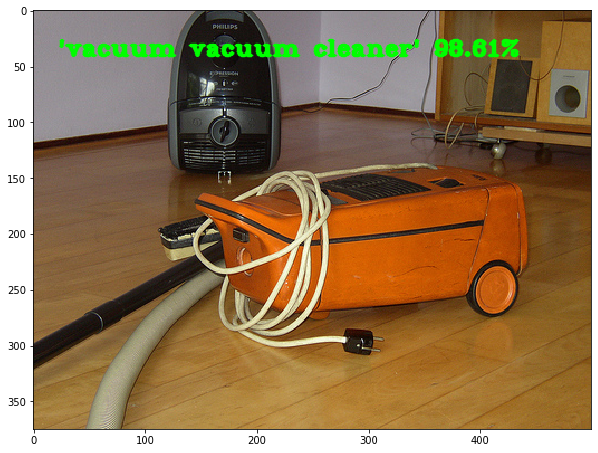

In [12]:
import json
import numpy as np

test_idx = 2
img_path = img_path_list[test_idx]

with open(img_path, mode='rb') as file:
    payload = bytearray(file.read())
    
sm_runtime = boto3.Session().client('sagemaker-runtime')

response = sm_runtime.invoke_endpoint(EndpointName=predictor.endpoint_name,
                                      ContentType='application/x-image',
                                      Body=payload)
result = json.loads(response['Body'].read().decode())
pred_cls_idx, pred_cls_str, prob = parse_result(result)

print(response)
print(f'Most likely class: {pred_cls_str}, {prob:.2f}%')

In [13]:
import time
start = time.time()
for _ in range(100):
    rresponse = sm_runtime.invoke_endpoint(EndpointName=predictor.endpoint_name,
                                      ContentType='application/x-image',
                                      Body=payload)
inf1_inference_time = (time.time()-start)
print(f'inf1 optimized inference time is {inf1_inference_time:.4f} ms')

inf1 optimized inference time is 9.2948 ms


## Endpoint Clean-up

SageMaker Endpoint로 인한 과금을 막기 위해, Endpoint를 삭제합니다.

In [14]:
sess.delete_endpoint(predictor.endpoint_name)

<br>

# 3. 컴파일러 옵션을 사용하여 다중 코어용 모델 컴파일 후 배포
---

이 섹션에서는 `inf1.xlarge`에서 지원하는 4개의 코어를 모두 활용해 보겠습니다. 본 예제에서는 모델 정의 시
`env={'NEURONCORE_GROUP_SIZES': '2', 'SAGEMAKER_MODEL_SERVER_WORKERS': '2'}` 로 지정하고 모델 컴파일 시 뉴런 코어 개수를 2로 조절합니다. (`compiler_options={"num-neuroncores": 2}`)

In [15]:
import boto3
import sagemaker
import time
from sagemaker.utils import name_from_base

role = sagemaker.get_execution_role()
sess = sagemaker.Session()
region = sess.boto_region_name
bucket = sess.default_bucket()

compilation_job_name = name_from_base('TorchVision-ResNet18-Neo-Inf1')

model_key = '{}/model/model.tar.gz'.format(compilation_job_name)
model_path = 's3://{}/{}'.format(bucket, model_key)
boto3.resource('s3').Bucket(bucket).upload_file('model.tar.gz', model_key)
print("Uploaded model to s3:")
print(model_path)

sm_client = boto3.client('sagemaker')
compiled_model_path = 's3://{}/{}/output'.format(bucket, compilation_job_name)
print("Output path for compiled model:")
print(compiled_model_path)

Uploaded model to s3:
s3://sagemaker-us-east-1-143656149352/TorchVision-ResNet18-Neo-Inf1-2020-12-31-05-37-11-778/model/model.tar.gz
Output path for compiled model:
s3://sagemaker-us-east-1-143656149352/TorchVision-ResNet18-Neo-Inf1-2020-12-31-05-37-11-778/output


## 모델 컴파일
컴파일러 옵션에서 뉴런 코어 수를 2로 전달합니다.

In [16]:
from sagemaker.pytorch.model import PyTorchModel

pytorch_model = PyTorchModel(model_data=model_path,
                             role=role,
                             entry_point='resnet18.py',
                             framework_version='1.5.1',
                             py_version='py3',
                             env={'NEURONCORE_GROUP_SIZES': '2', 'SAGEMAKER_MODEL_SERVER_WORKERS': '2'}
                             )
neo_model = pytorch_model.compile(target_instance_family='ml_inf1',
                                  input_shape={'input0':[1,3,224,224]},
                                  output_path=compiled_model_path,
                                  framework='pytorch',
                                  framework_version='1.5.1',
                                  role=role,
                                  job_name=compilation_job_name,
                                  compiler_options={"num-neuroncores": 2})

?...!

## 컴파일된 모델 배포

SageMaker가 관리하는 배포 클러스터를 프로비저닝하고 추론 컨테이너를 배포하기 때문에, 추론 서비스를 시작하는 데에는 약 5~10분 정도 소요됩니다.

In [17]:
%%time
predictor = neo_model.deploy(instance_type='ml.inf1.xlarge', initial_instance_count=1)

-------------!CPU times: user 1.51 s, sys: 181 ms, total: 1.69 s
Wall time: 6min 34s


{'ResponseMetadata': {'RequestId': '968bb43c-c827-481d-bf76-92247c2f685e', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '968bb43c-c827-481d-bf76-92247c2f685e', 'x-amzn-invoked-production-variant': 'AllTraffic', 'date': 'Thu, 31 Dec 2020 05:44:17 GMT', 'content-type': 'application/json', 'content-length': '20157'}, 'RetryAttempts': 0}, 'ContentType': 'application/json', 'InvokedProductionVariant': 'AllTraffic', 'Body': <botocore.response.StreamingBody object at 0x7f864cf0d400>}
Most likely class:  'vacuum vacuum cleaner', 98.68%


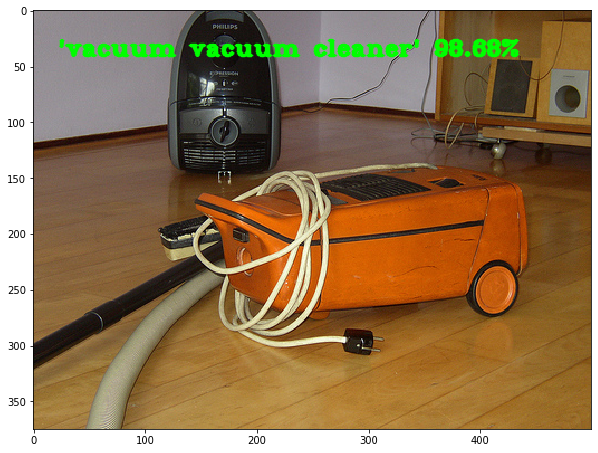

In [18]:
import json
import numpy as np

test_idx = 2
img_path = img_path_list[test_idx]

with open(img_path, mode='rb') as file:
    payload = bytearray(file.read())
    
sm_runtime = boto3.Session().client('sagemaker-runtime')

response = sm_runtime.invoke_endpoint(EndpointName=predictor.endpoint_name,
                                      ContentType='application/x-image',
                                      Body=payload)
result = json.loads(response['Body'].read().decode())
pred_cls_idx, pred_cls_str, prob = parse_result(result)

print(response)
print(f'Most likely class: {pred_cls_str}, {prob:.2f}%')

In [19]:
import time
start = time.time()
for _ in range(100):
    rresponse = sm_runtime.invoke_endpoint(EndpointName=predictor.endpoint_name,
                                      ContentType='application/x-image',
                                      Body=payload)
inf1_inference_time = (time.time()-start)
print(f'inf1 optimized inference time is {inf1_inference_time:.4f} ms')

inf1 optimized inference time is 8.4174 ms


In [20]:
sess.delete_endpoint(predictor.endpoint_name)